In [1]:
import os
import sys
import cv2
import sklearn
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

from local_config import CURRENT_DIR
sys.path.append(os.path.join(CURRENT_DIR, ".."))
from config import Config
from data_loader import BehavioralDataset
from data_loader import batch_generator

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from config import Config
from data_loader import BehavioralDataset
from models import BehavioralModel
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

def load_data(dataset):
    x_train, y_train = dataset.load_data_with_bias()
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)
    return x_train, x_val, y_train, y_val

In [3]:
dt_config = Config()
dataset = BehavioralDataset(path_to_data=dt_config.DATA_PATH)
x_train, x_val, y_train, y_val = load_data(dataset)

  1%|█▌                                                                                                                   | 59/4429 [00:00<00:07, 586.61it/s]

loading data ...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4429/4429 [00:07<00:00, 615.36it/s]
2719it [00:02, 1186.12it/s]


In [4]:
model = BehavioralModel(input_shape=(160, 320, 3))
callbacks = [
    ModelCheckpoint(
        dt_config.SAVED_MODELS, monitor="val_loss", verbose=1, save_best_only=True, mode="auto", period=1
    ),
    ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=10, verbose=0, mode="auto", min_lr=0.00001),
    EarlyStopping(monitor="val_loss", min_delta=0, patience=15, verbose=0, mode="auto"),
]

history = model.fit_generator(
    batch_generator(x_train, y_train, dt_config.BATCH_SIZE),
    epochs=dt_config.EPOCHS,
    steps_per_epoch=(20000-1)//dt_config.BATCH_SIZE +1,
    validation_data=batch_generator(x_val, y_val, dt_config.BATCH_SIZE, False),
    validation_steps=(len(x_val)-1)//dt_config.BATCH_SIZE +1,
    callbacks=callbacks,
)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 160, 320, 3)]     0         
_________________________________________________________________
lambda (Lambda)              (None, 160, 320, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 78, 158, 24)       1824      
_________________________________________________________________
batch_normalization (BatchNo (None, 78, 158, 24)       96        
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 78, 158, 24)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 37, 77, 36)        21636     
_________________________________________________________________
batch_normalization_1 (Batch (None, 37, 77, 36)        144   

Epoch 14/100
156/157 [============================>.] - ETA: 0s - loss: 0.2513
Epoch 00014: val_loss improved from 0.17076 to 0.15729, saving model to /home/buggy/publicWorkspace/dev/CarND-Behavioral-Cloning-P3/saved_models/best_model.h5
157/157 [==============================] - 70s 445ms/step - loss: 0.2512 - val_loss: 0.1573
Epoch 15/100
156/157 [============================>.] - ETA: 0s - loss: 0.2319
Epoch 00015: val_loss did not improve from 0.15729
157/157 [==============================] - 68s 435ms/step - loss: 0.2318 - val_loss: 0.1611
Epoch 16/100
156/157 [============================>.] - ETA: 0s - loss: 0.2262
Epoch 00016: val_loss improved from 0.15729 to 0.14906, saving model to /home/buggy/publicWorkspace/dev/CarND-Behavioral-Cloning-P3/saved_models/best_model.h5
157/157 [==============================] - 69s 441ms/step - loss: 0.2261 - val_loss: 0.1491
Epoch 17/100
156/157 [============================>.] - ETA: 0s - loss: 0.2070
Epoch 00017: val_loss did not improve f

156/157 [============================>.] - ETA: 0s - loss: 0.1488
Epoch 00047: val_loss did not improve from 0.12801
157/157 [==============================] - 70s 444ms/step - loss: 0.1490 - val_loss: 0.1464
Epoch 48/100
156/157 [============================>.] - ETA: 0s - loss: 0.1463
Epoch 00048: val_loss did not improve from 0.12801
157/157 [==============================] - 69s 442ms/step - loss: 0.1465 - val_loss: 0.1297
Epoch 49/100
156/157 [============================>.] - ETA: 0s - loss: 0.1467
Epoch 00049: val_loss did not improve from 0.12801
157/157 [==============================] - 69s 442ms/step - loss: 0.1468 - val_loss: 0.1393
Epoch 50/100
156/157 [============================>.] - ETA: 0s - loss: 0.1446
Epoch 00050: val_loss did not improve from 0.12801
157/157 [==============================] - 69s 442ms/step - loss: 0.1446 - val_loss: 0.1468
Epoch 51/100
156/157 [============================>.] - ETA: 0s - loss: 0.1467
Epoch 00051: val_loss did not improve from 0.1

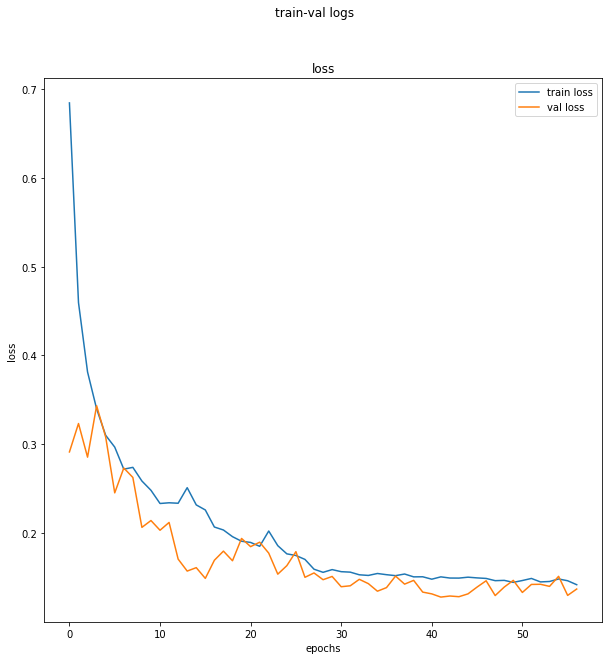

<Figure size 432x288 with 0 Axes>

In [5]:
from matplotlib import pyplot as plt

train_loss = history.history["loss"]
val_loss = history.history["val_loss"]
if "acc" in history.history:
   train_acc = history.history["acc"]
   val_acc = history.history["val_acc"]
epoch_nums = len(train_loss)

if "acc" in history.history:
   fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,10))
   loss_ax = ax[0]
else:
   fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
   loss_ax = ax

loss_ax.set_xlabel("epochs");
loss_ax.set_ylabel("loss")
loss_ax.set_title("loss")
loss_ax.plot(range(0,epoch_nums), train_loss, label="train loss")
loss_ax.plot(range(0,epoch_nums), val_loss, label="val loss")
loss_ax.legend()

if "acc" in history.history:
   ax[1].set_xlabel("epochs");
   ax[1].set_ylabel("val")
   ax[1].set_title("accuracy")
   ax[1].plot(range(0,epoch_nums), train_acc, label="train acc")
   ax[1].plot(range(0,epoch_nums), val_acc, label="val acc")
   ax[1].legend()

plt.suptitle("train-val logs")
plt.show()
plt.savefig("train_val_logs.png")